In [1]:
import numpy as np   # import needed libraries
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.signal import argrelextrema



In [2]:
#Create uniform y-axis limit
def create_ylimit(df):
    #find the standard deviation and mean of each column from the dataset without zeros
    df_limit=df.replace(0, np.nan)
    std=df_limit.std()
    mean=df_limit.mean()
    #Find mean and standard deviation of all of the data
    df_mean=np.mean(mean)
    df_std =np.mean(std)
    #y limit = mean of the dataframe plus 3 standard deviations
    y_limit = df_mean +3*df_std
    return y_limit

def plot_night_test(df):
    #Make a copy of the dataframe and create two columns for the difference between the light values and for the date and time
    dfc = df.copy()
    dfc['diff'] = dfc.Light.diff()
    dfc[["day", "time"]] = dfc["Date-Time"].str.split(" ", expand = True)
    #Separate by the difference to determine when the light is coming on or going off
    df_off = dfc.loc[dfc['diff'] == 1]
    df_on = dfc.loc[dfc['diff'] == -1]
    #display(dfc)
    #Assign variable from the lists
    start1 = dfc.time.values[0]
    end1 = df_off.time.values[0]
    start2 = df_on.time.values[0]
    end2 = dfc.time.values[-1]

    return start1, start2, end1, end2

#Plot activity in subplots
#Imput:Dataframe, List of spiders in df, Specific Spider from list, 
#Label for subplots, variable from "create_ylimit" funnction 
#All variables will be named in final raster plot function
def plot_raster( df, column, spider, ax, y, num_days, min_day): 
    
    for i in range(0,num_days):
        #Separate dataframe into sections of 1440 minutes(minutes in a day) and plot the 
        #activity for each day
        ax[i].plot(df['time'][min_day*i:min_day*(i+1)], df[column[spider]][min_day*i:min_day*(i+1)], color='blue')
        #Label each day
        ax[i].set_ylabel('d'+str(i+1))
        ax[i].set_xticks([])
        # the y limit is the mean plus 3 standard deviations
        ax[i].set_ylim(0,y)
        #setting instructions for shading the graph when the lights are off
        df1=df[min_day*(i):min_day*(i+1)]
        df1=df1.reset_index()
        #Make DD plots all grey
        if np.mean(df1.Light)==0:
            ax[i].set_facecolor("silver")
        elif np.mean(df1.Light)>.55:
            print('Constant Light')
        #Run function to determine when lights are off during LD cycle
        else:
            start1, start2, end1, end2 = plot_night_test(df1)
            #print(start1, end1,start2, end2)
            ax[i].axvspan(start1, end1, alpha=0.5, color='grey')
            ax[i].axvspan(start2, end2,alpha=0.5, color='grey')
            
#Combine all funtions to make raster plots for all spiders given a data frame and list of spiders
def spider_raster(df):
    column=df.columns[1:]
    #create a copy and separate the date and time for reference
    df_time = df.copy()
    df_time=df_time.reset_index()
    df_time[["day", "time"]] = df_time["Date-Time"].str.split(" ", expand = True)
    #for loop for creating figures for the number of spiders in the dataframe
    for spider in  range(len(column)):
        #Determine length of usable data for each spider
        dftest=df[column[spider]].dropna()
        print(column[spider])
        total_time = len(dftest.index)
        num_days = total_time//min_day
        #Plot subplots
        fig, ax=plt.subplots(num_days,1, figsize=(8,12), sharey=True)
        fig.suptitle('The Free Running Period of: ' + column[spider], fontsize=16)        
        #setting the y axis limit
        y = create_ylimit(df) 
        #plotting the raster plots
        plot_raster(df_time, column, spider, ax, y, num_days, min_day)
        #plot x axis
        x=int(1440/4)
        ax[num_days-1].set_xticks([0,x,2*x,3*x,4*x],['0:00','6:00','12:00','18:00','24:00'])
        plt.xlabel('Subjective Time')
        #save figure
        #fig.savefig(column[spider] +'raster_DD_TEMP')
        plt.show()
        print('Next spider')
      
    
    
    
    
######################



#Combine all funtions to make raster plots for all spiders given a data frame and list of spiders
def spider_raster_per(df, per):
    column=df.columns[1:]
    perT = per.T
    #create a copy and separate the date and time for reference
    df_time = df.copy()
    df_time=df_time.reset_index()
    df_time[["day", "time"]] = df_time["Date-Time"].str.split(" ", expand = True)
    #for loop for creating figures for the number of spiders in the dataframe
    for spider in  range(len(column)):
        #Determine length of usable data for each spider
        dftest=df[column[spider]].dropna()
        print(column[spider])
        min_day = int((perT[column[spider]].values) * 60)
        #sub_mins_day = per.iloc[0]['A']
        #print(min_day)
        total_time = len(df.index)
        num_days = total_time//min_day
        #Plot subplots
        fig, ax=plt.subplots(num_days,1, figsize=(8,12), sharey=True)
        fig.suptitle('The Free Running Period of: ' + column[spider], fontsize=16)        
        #setting the y axis limit
        y = create_ylimit(df) 
        #plotting the raster plots
        plot_raster(df_time, column, spider, ax, y, num_days, min_day)
        #plot x axis
        x=int(1440/4)
        ax[num_days-1].set_xticks([0,x,2*x,3*x,4*x],['0:00','6:00','12:00','18:00','24:00'])
        plt.xlabel('Subjective Time')
        #save figure
        #fig.savefig(column[spider] +'raster_DD_Period')
        #plt.show()
        print('Next spider')




In [3]:
# Function to read in a dataframe column of spider data (a series) and the interval between measurements
# in minutes and, to return the period (in minutes) and the power from the Lomb-Scargle periodogram method
# Note that the variables start_index and end_index were set by trial and error, and could need adjustment
# if the results for period and power seem questionable. 

# Now expanded to also read in a file_base string and a spider_string (with a spider number in the form 's#' typically),
# and save a png file of the calculated LS Periodogram. Also now returns a 'false alarm probability', which estimates
# the chance that the peak maximum observed in the periodogram could arise by random chance if the data were Gaussian
# noise with no periodic component

def Function_LS_Deluxe(file_base,spider_string,series,min_interval):  # set min_interval to the time between measurements in minutes

    steps = len(series)    # find number of items in the input spider data
    time_input = np.linspace(1,steps,num=steps)  # create a time grid for the LombScargle routine
#    ls = LombScargle(time_input, series, normalization='standard') # calculate LombScargle p-gram and put in object 'ls'
#    ls = LombScargle(time_input, series, normalization='model') # calculate LombScargle p-gram and put in object 'ls'
#    ls = LombScargle(time_input, series, normalization='log') # calculate LombScargle p-gram and put in object 'ls'
    ls = LombScargle(time_input, series, normalization='psd') # calculate LombScargle p-gram and put in object 'ls'
    min_freq = 1./(34.*60.) * min_interval
    max_freq = 1./(14.*60.) * min_interval
#    print(min_freq, max_freq)
    frequency, power = ls.autopower(minimum_frequency=min_freq,maximum_frequency=max_freq,samples_per_peak=50)  
                                # extract the frequency and power arrays with specified frequency limits and grid spacing
    period = 1./frequency * min_interval / 60.  # create an array of periods from the array of frequencies
    max_power = np.amax(power, axis = 0)  # find the value of the maximum power within restricted range
    period_max_hr = np.abs(1/(frequency[np.where(power == max_power)]))*min_interval / 60.  # locate 
                                                                        # period where max power occurs and express in hours
    false_alarm_prob = ls.false_alarm_probability(max_power) # extract the false alarm probability for peak with height max_power
    plt.figure()    # create periodogram figure
    title_string = spider_string 
    filename = spider_string+'.png'   # construct output filename for the periodogram 
    plt.title(title_string)   # set title
    plt.xlabel("Period (hr)")  # set x-axis label
    plt.ylabel("Lomb-Scargle Amplitude") # set y-axis label
    plt.plot(period,power,linewidth=2)  # plot the periodogram
    plt.plot(period_max_hr,max_power,color='red',marker='o')  # put a circular point at the max peak
    #plt.savefig(filename,dpi=300)  # save the periodogram file
    plt.close()  # close the periodogram figure
    return (period_max_hr.item(), max_power, false_alarm_prob)  # returns period, max_power, false_alarm as floating points

# Function to take in base filenames (i.e., with '.csv' stripped off) of spider data and spider metafile  
# (with Alive/Circadian specified) and to return a dataframe of only the Alive/Circadian spiders with their 
# Periods/Amplitudes/False Alarm Probabilities using the Lomb-Scargle Periodogram method from astropy. 
# Each spider also has a periodogram output as a 300-dpi .png file.
# Note this function calls the function Function_LS_Deluxe in the above cell

def LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base):
    spider_data_filename = spider_datafile_base + '.csv'  # reconstruct spider data full filename
    df_spider = pd.read_csv(spider_data_filename, index_col=0)   # read in all the spider data from the given filename
    df_spider.index = pd.to_datetime(df_spider.index)            # reset indexes to datetime format for convenience
    spiderac_list_all = df_spider.columns.values.tolist()       # extract list of all column names from dataframe
    spiderac_list =  spiderac_list_all[1:]                      #  restrict list to column names that are spider names
    print(spiderac_list)
    print(len(spiderac_list))
    output_columns = ['Spider','Period','Amplitude','p value']    # prepare column names for the output dataframe
    df_output = pd.DataFrame(columns = output_columns)  # create an empty dataframe with the output column names
    for spider_name in spiderac_list:             # loop over the names of the alive/circadian spiders
        column_name = spider_name                 # set the current column name within the spider dataframe 
#        df_spider[column_name] = df_spider[column_name].fillna(0)  # replace any stray values with zeroes to prevent errors
        column = df_spider[column_name].dropna()           # get the column (series) data for the current spider
#        print(type(column))
#        print(spider_name, ' ',column.max())
        if (column.max()>0):  # prevent error that occurs when series of data is all zero
            dt = df_spider.index.minute[1]-df_spider.index.minute[0]  # use the datetime format to find measurement interval
            pmax, amp, false_alarm = Function_LS_Deluxe(spider_datafile_base,spider_name,column,dt) 
                                                    # call above function to find period, max power, and false alarm probability
        else:
            pmax, amp, false_alarm = [0.0,0.0,1.0]
        df_add = pd.DataFrame([[spider_name,pmax,amp,false_alarm]],columns=output_columns)  # prepare a row to be added to the output dataframe
        df_output = df_output.append(df_add, ignore_index = True)     # add a row to the output datafram
    return(df_output)                             # return the full output dataframe

In [4]:
#Input:
#dfa = pd.read_csv("Monitor 5.csv", index_col=0)
min_day=1440
#total_time = len(df.index)
#num_days = total_time//min_day

#display(df)
#df=dfa.iloc[:(9*1440)]
#df.to_csv('USE-Monitor 5.csv')
#df=pd.read_csv('USE-Monitor 5.csv', index_col=0)
#column=df.columns[1:]
#display(df)

In [5]:
dfa = pd.read_csv("Latrodectus mactans Monitor 1 Updated_LD.csv", index_col=0)
#dfa=dfa.iloc[9*1440:]
display(dfa)

Light  Monitor 1 Spider 1  Monitor 1 Spider 3  \
Date-Time                                                            
2017-08-12 00:00:00      0                 0.0                   0   
2017-08-12 00:01:00      0                 0.0                   4   
2017-08-12 00:02:00      0                10.0                   2   
2017-08-12 00:03:00      0                10.0                   0   
2017-08-12 00:04:00      0                 9.0                   0   
...                    ...                 ...                 ...   
2017-08-16 23:55:00      0                 0.0                   4   
2017-08-16 23:56:00      0                 0.0                   1   
2017-08-16 23:57:00      0                 0.0                   0   
2017-08-16 23:58:00      0                 0.0                   0   
2017-08-16 23:59:00      0                 0.0                   0   

                     Monitor 1 Spider 4  Monitor 1 Spider 5  \
Date-Time                                                     
2017-08-12 00:00:00                   0                   0   
2017-08-12 00:01:00                   3                   0   
2017-08-12 00:02:00                   0                   0   
2017-08-12 00:03:00                   7                   0   
2017-08-12 00:04:00                   4                   0   
...                                 ...                 ...   
2017-08-16 23:55:00                   0                   0   
2017-08-16 23:56:00                   0                   0   
2017-08-16 23:57:00                   0                   0   
2017-08-16 23:58:00                   0                   0   
2017-08-16 23:59:00                   4                   0   

                     Monitor 1 Spider 6  Monitor 1 Spider 7  \
Date-Time                                                     
2017-08-12 00:00:00                   0                   0   
2017-08-12 00:01:00                   0                   0   
2017-08-12 00:02:00                   4                   0   
2017-08-12 00:03:00                   4                   0   
2017-08-12 00:04:00                   3                   0   
...                                 ...                 ...   
2017-08-16 23:55:00                   0                   0   
2017-08-16 23:56:00                   0                   0   
2017-08-16 23:57:00                   0                   5   
2017-08-16 23:58:00                   0                   1   
2017-08-16 23:59:00                   0                   0   

                     Monitor 1 Spider 8  Monitor 1 Spider 10  
Date-Time                                                     
2017-08-12 00:00:00                   0                   25  
2017-08-12 00:01:00                   0                    9  
2017-08-12 00:02:00                   0                    0  
2017-08-12 00:03:00                   0                   10  
2017-08-12 00:04:00                   0                    4  
...                                 ...                  ...  
2017-08-16 23:55:00                   0                    0  
2017-08-16 23:56:00                   0                    0  
2017-08-16 23:57:00                   0                    0  
2017-08-16 23:58:00                   0                    0  
2017-08-16 23:59:00                   0                    0  

[7200 rows x 9 columns]

Monitor 1 Spider 1


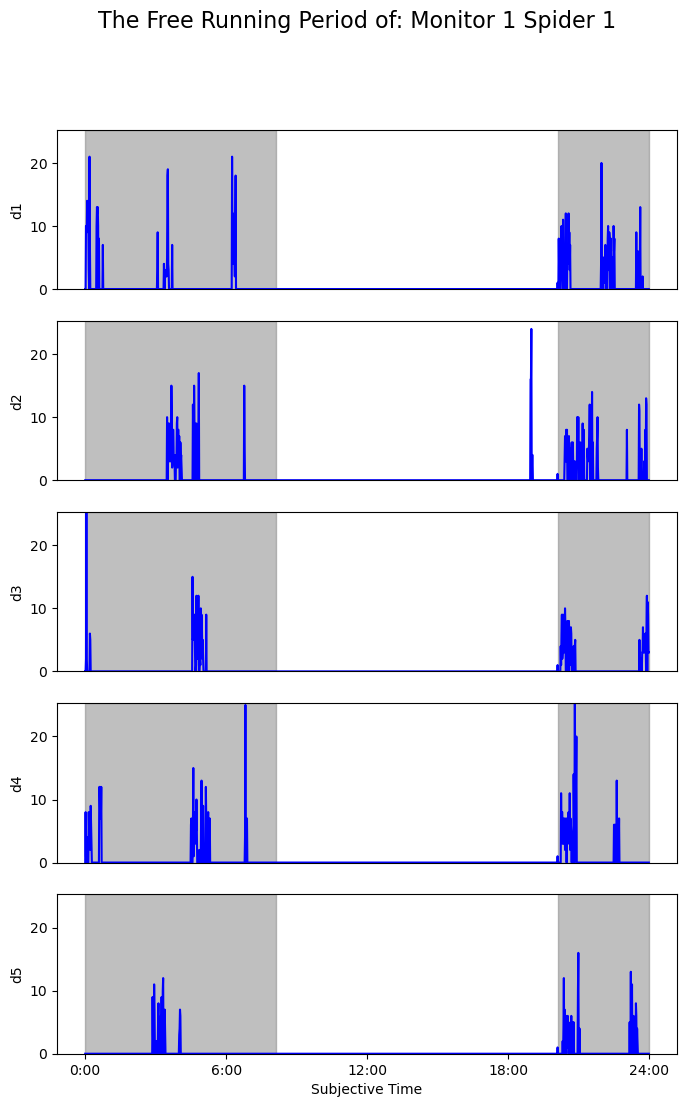

Next spider
Monitor 1 Spider 3


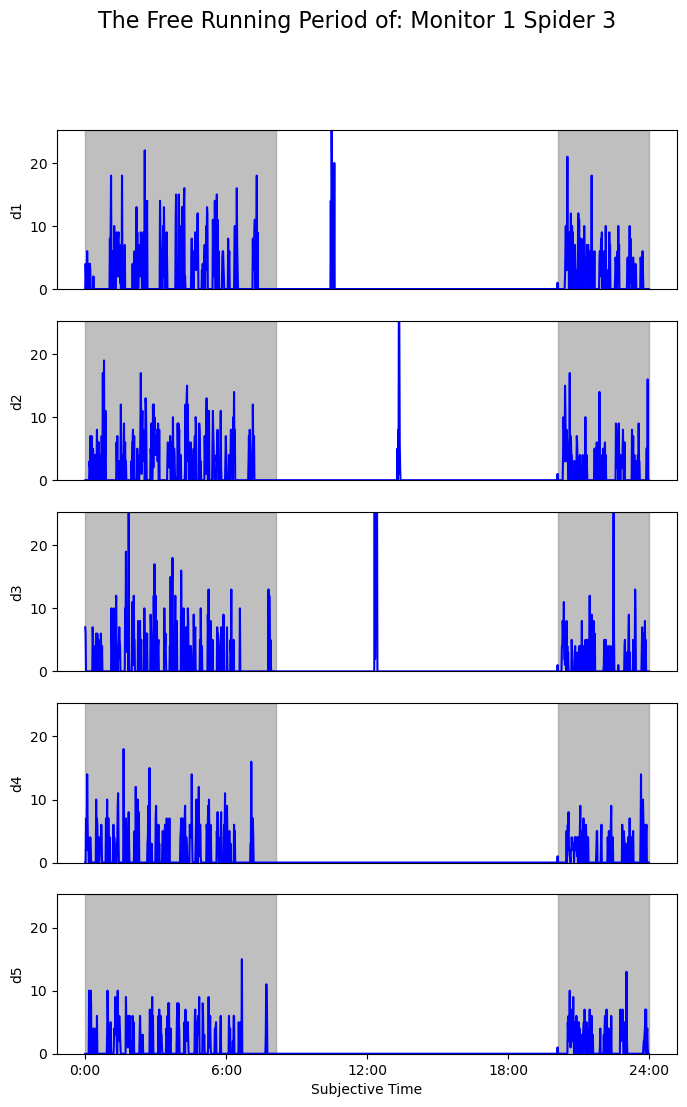

Next spider
Monitor 1 Spider 4


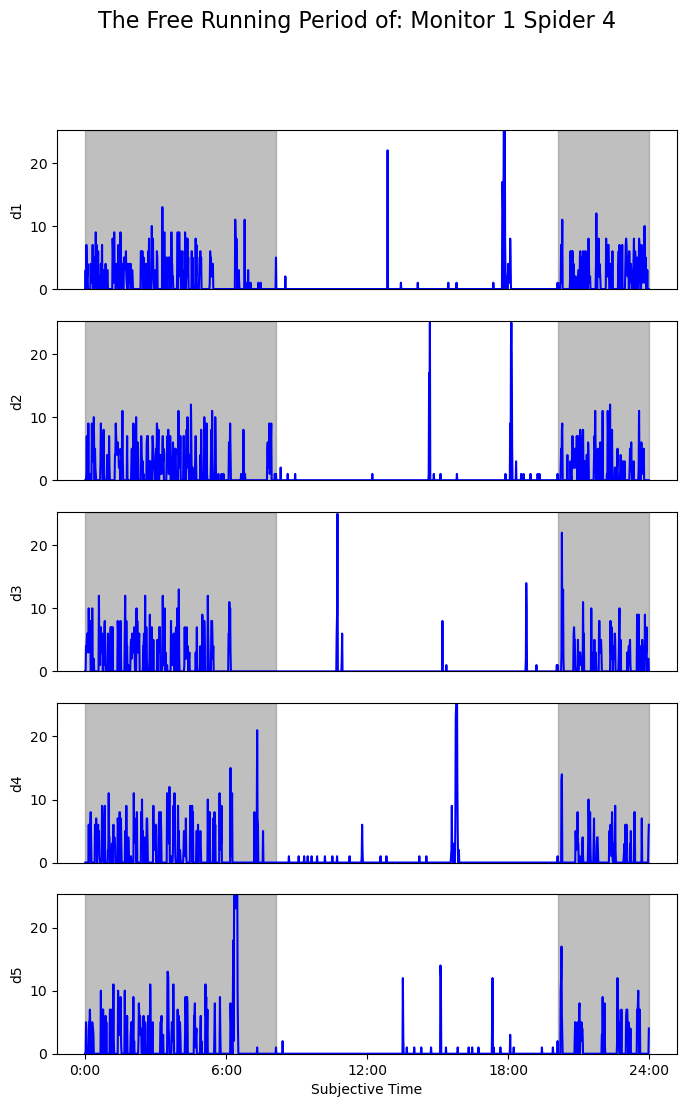

Next spider
Monitor 1 Spider 5


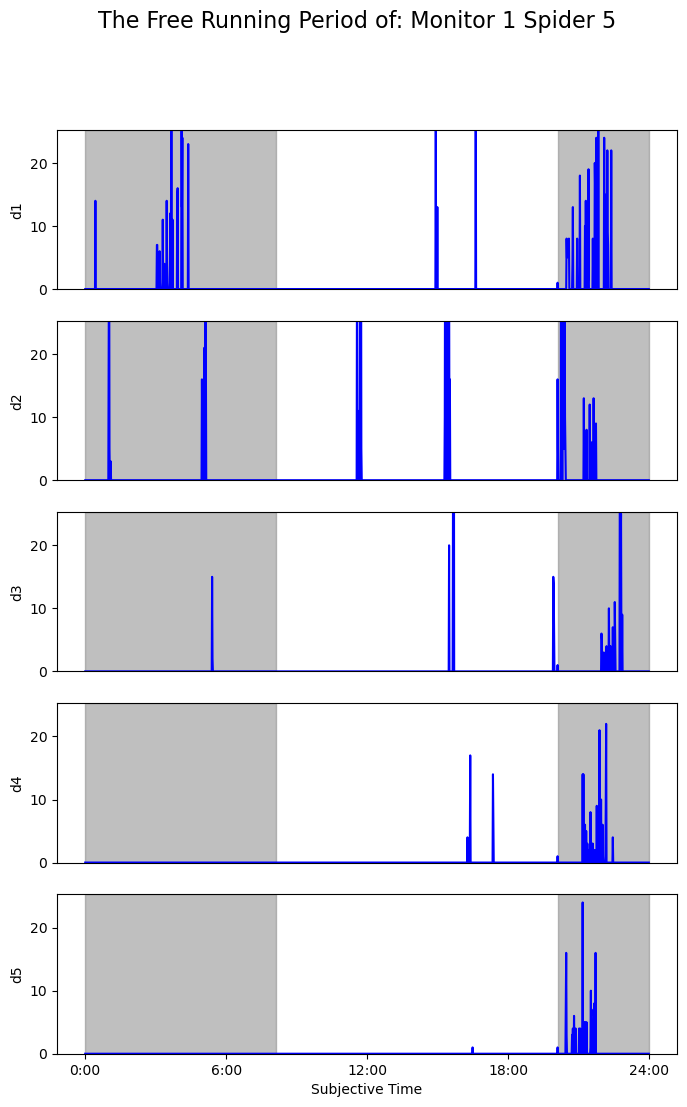

Next spider
Monitor 1 Spider 6


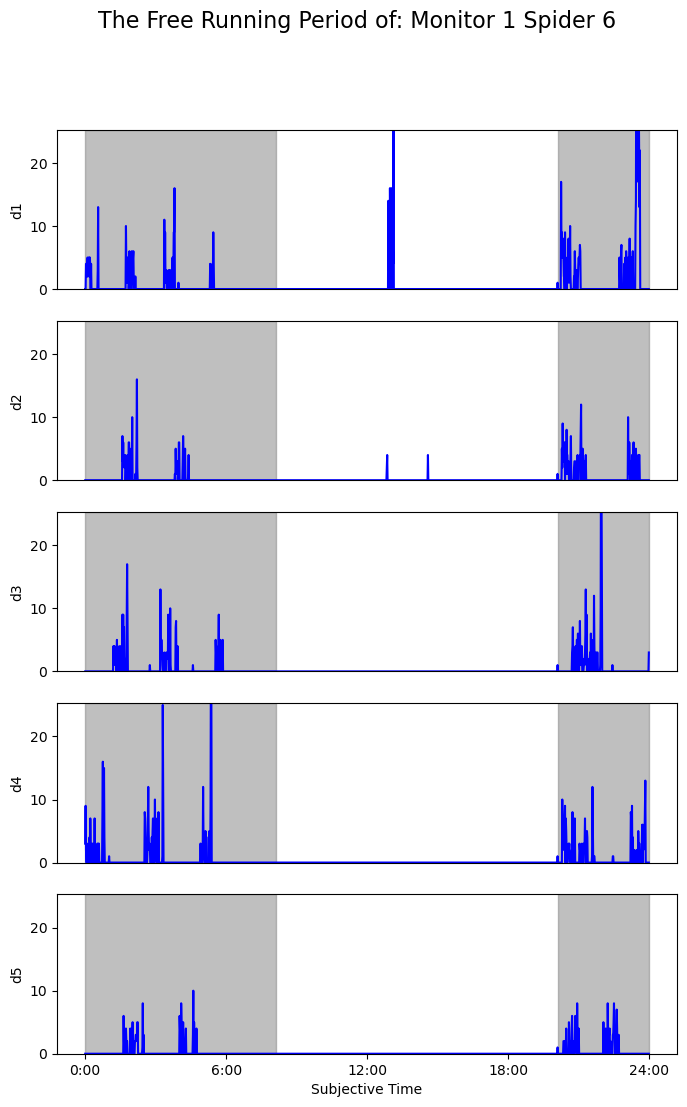

Next spider
Monitor 1 Spider 7


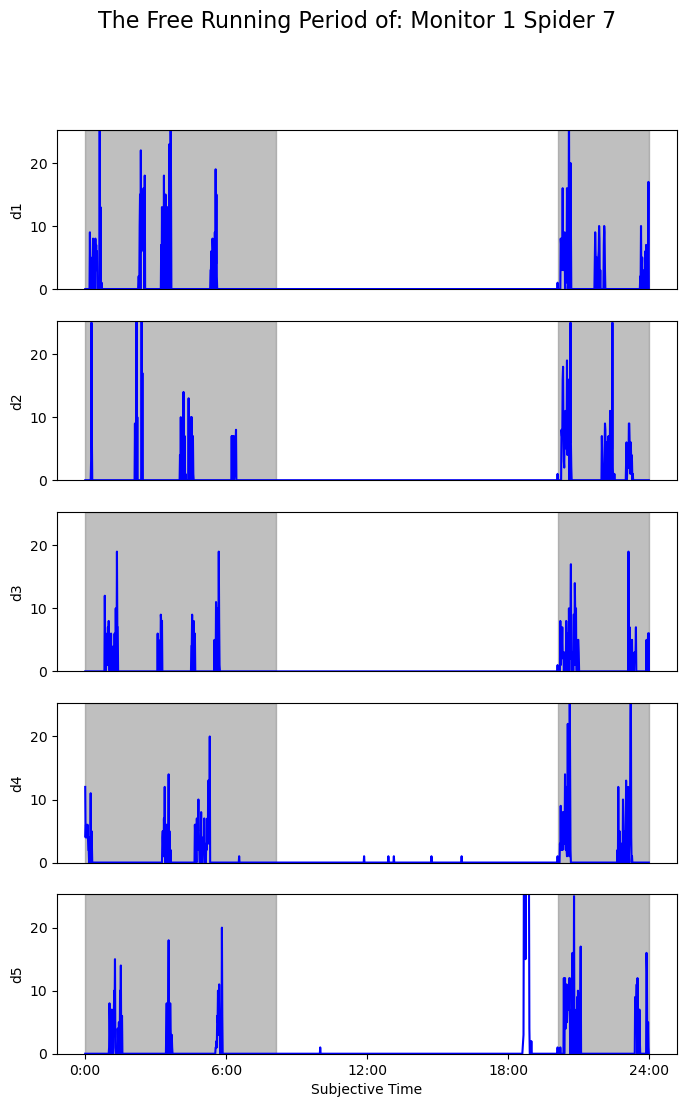

Next spider
Monitor 1 Spider 8


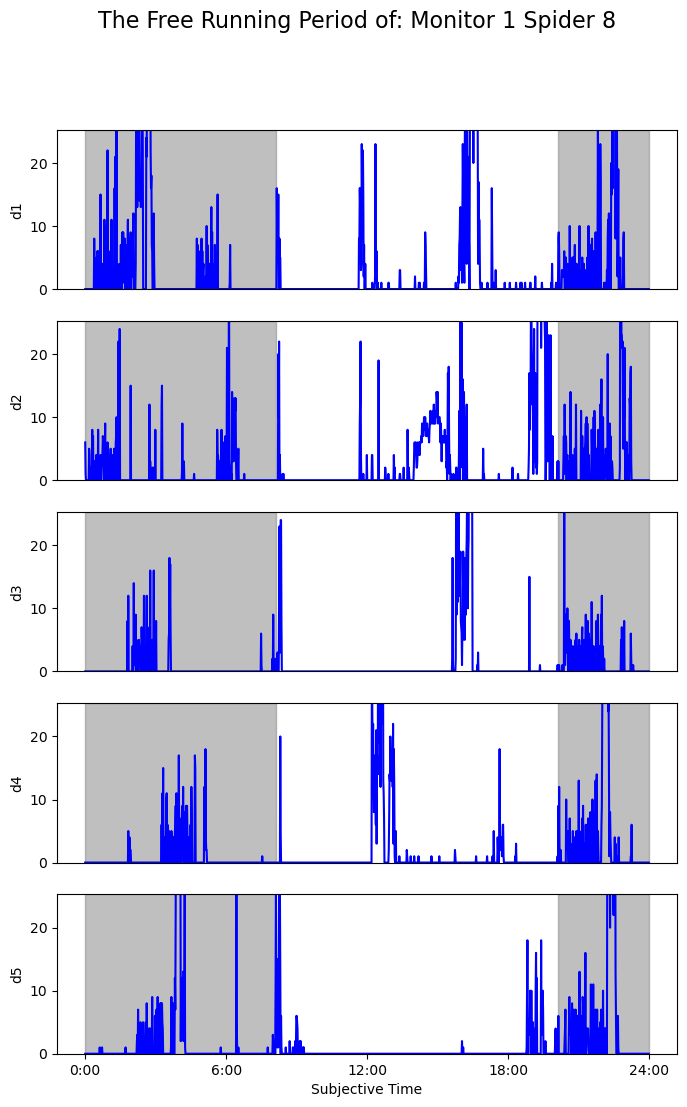

Next spider
Monitor 1 Spider 10


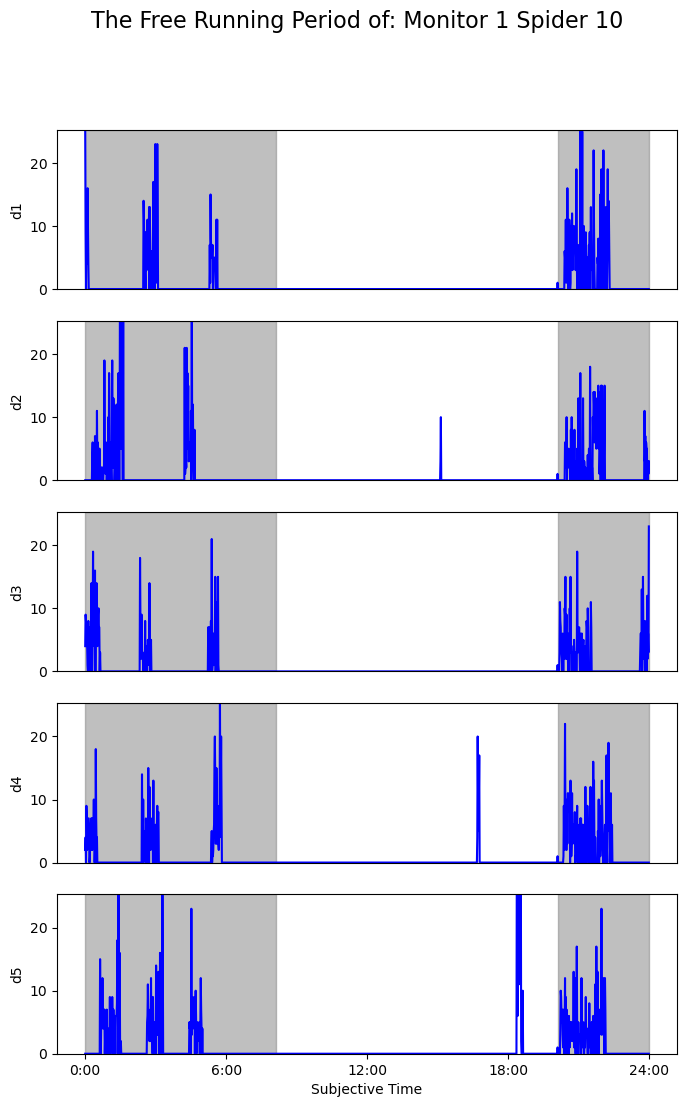

Next spider


In [6]:
spider_raster(dfa)

In [31]:
df = pd.read_csv("Latrodectus mactans  Monitor 1 Updated_DD.csv", index_col=0)
min_day=1440
df=df.fillna(0)
display(df)



Light  Monitor 1 Spider 1  Monitor 1 Spider 3  \
Date-Time                                                            
2017-08-17 00:00:00      0                 0.0                   0   
2017-08-17 00:01:00      0                 0.0                   0   
2017-08-17 00:02:00      0                 0.0                   0   
2017-08-17 00:03:00      0                 0.0                   0   
2017-08-17 00:04:00      0                 0.0                   0   
...                    ...                 ...                 ...   
2017-08-28 23:55:00      0                 0.0                   0   
2017-08-28 23:56:00      0                 0.0                   0   
2017-08-28 23:57:00      0                 0.0                   0   
2017-08-28 23:58:00      0                 0.0                   0   
2017-08-28 23:59:00      0                 0.0                   1   

                     Monitor 1 Spider 4  Monitor 1 Spider 5  \
Date-Time                                                     
2017-08-17 00:00:00                   7                   0   
2017-08-17 00:01:00                   2                   0   
2017-08-17 00:02:00                   4                   0   
2017-08-17 00:03:00                   0                   0   
2017-08-17 00:04:00                   4                   0   
...                                 ...                 ...   
2017-08-28 23:55:00                   3                   0   
2017-08-28 23:56:00                   0                   0   
2017-08-28 23:57:00                   0                   0   
2017-08-28 23:58:00                   0                   0   
2017-08-28 23:59:00                   0                   0   

                     Monitor 1 Spider 6  Monitor 1 Spider 7  \
Date-Time                                                     
2017-08-17 00:00:00                   0                   0   
2017-08-17 00:01:00                   0                   8   
2017-08-17 00:02:00                   0                   1   
2017-08-17 00:03:00                   0                   0   
2017-08-17 00:04:00                   0                   0   
...                                 ...                 ...   
2017-08-28 23:55:00                   0                   0   
2017-08-28 23:56:00                   0                   0   
2017-08-28 23:57:00                   0                   0   
2017-08-28 23:58:00                   0                   0   
2017-08-28 23:59:00                   0                   0   

                     Monitor 1 Spider 8  Monitor 1 Spider 10  
Date-Time                                                     
2017-08-17 00:00:00                   0                    0  
2017-08-17 00:01:00                   0                    0  
2017-08-17 00:02:00                   0                    0  
2017-08-17 00:03:00                   0                    0  
2017-08-17 00:04:00                   0                    4  
...                                 ...                  ...  
2017-08-28 23:55:00                   0                    0  
2017-08-28 23:56:00                   0                    0  
2017-08-28 23:57:00                   0                    0  
2017-08-28 23:58:00                   1                    0  
2017-08-28 23:59:00                   0                    0  

[17280 rows x 9 columns]

Monitor 1 Spider 1


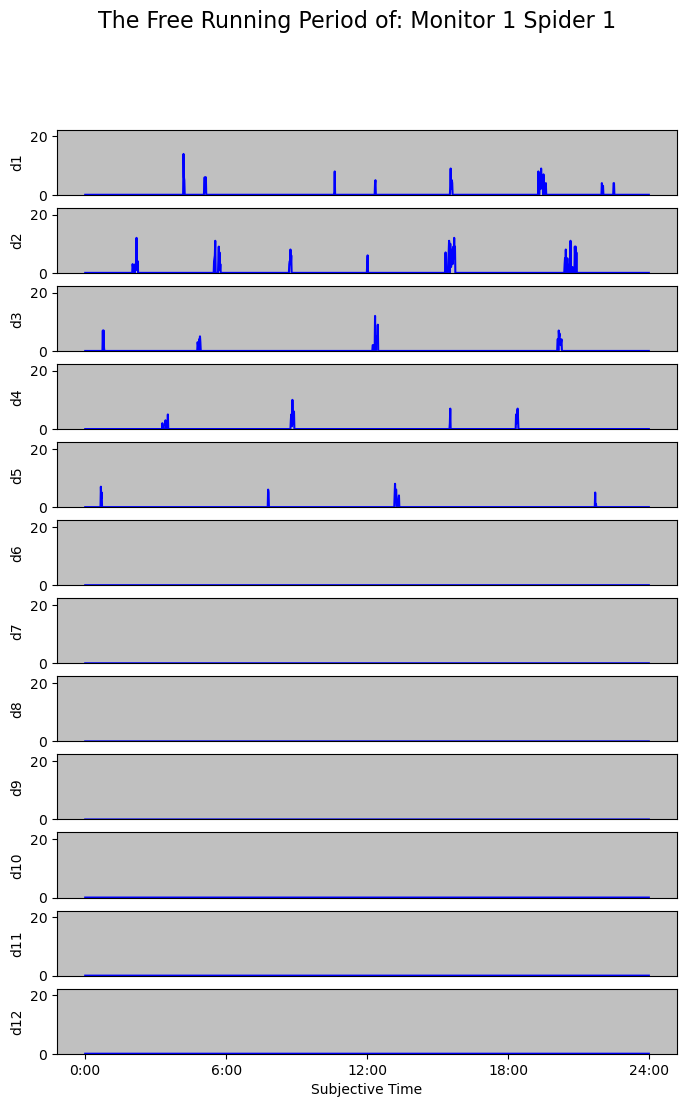

Next spider
Monitor 1 Spider 3


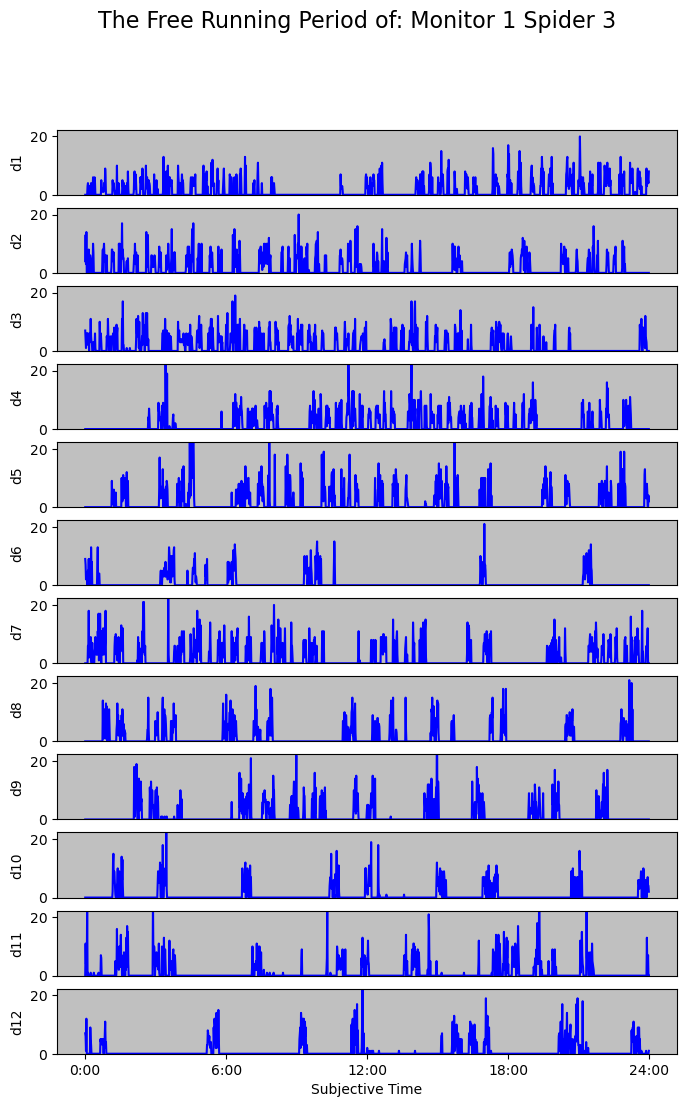

Next spider
Monitor 1 Spider 4


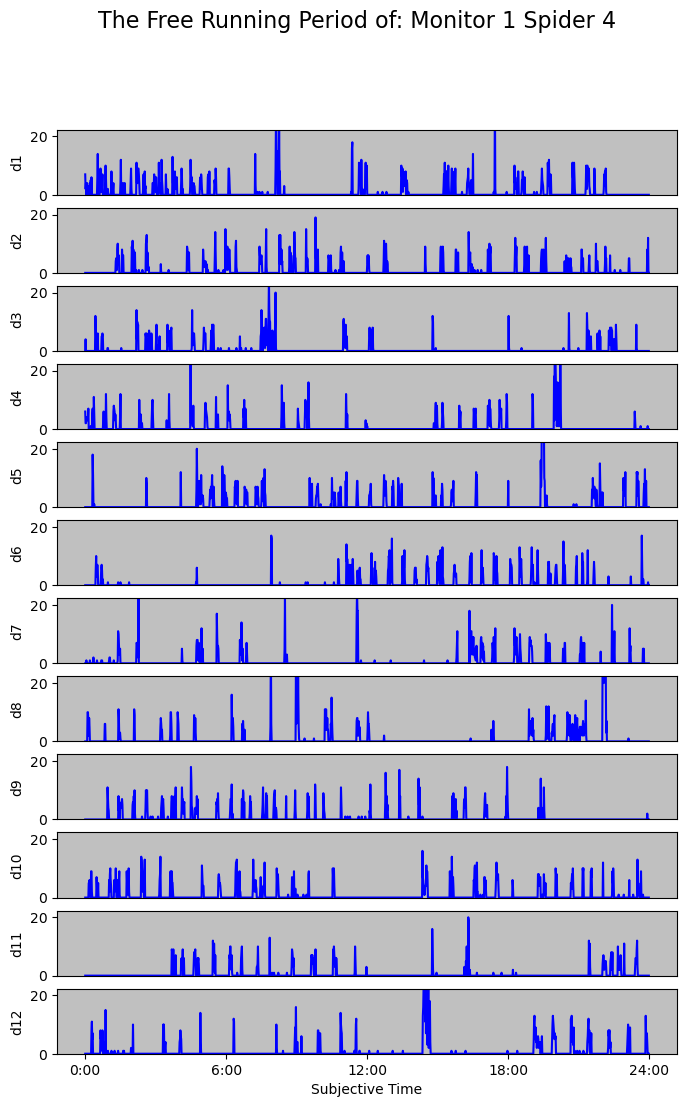

Next spider
Monitor 1 Spider 5


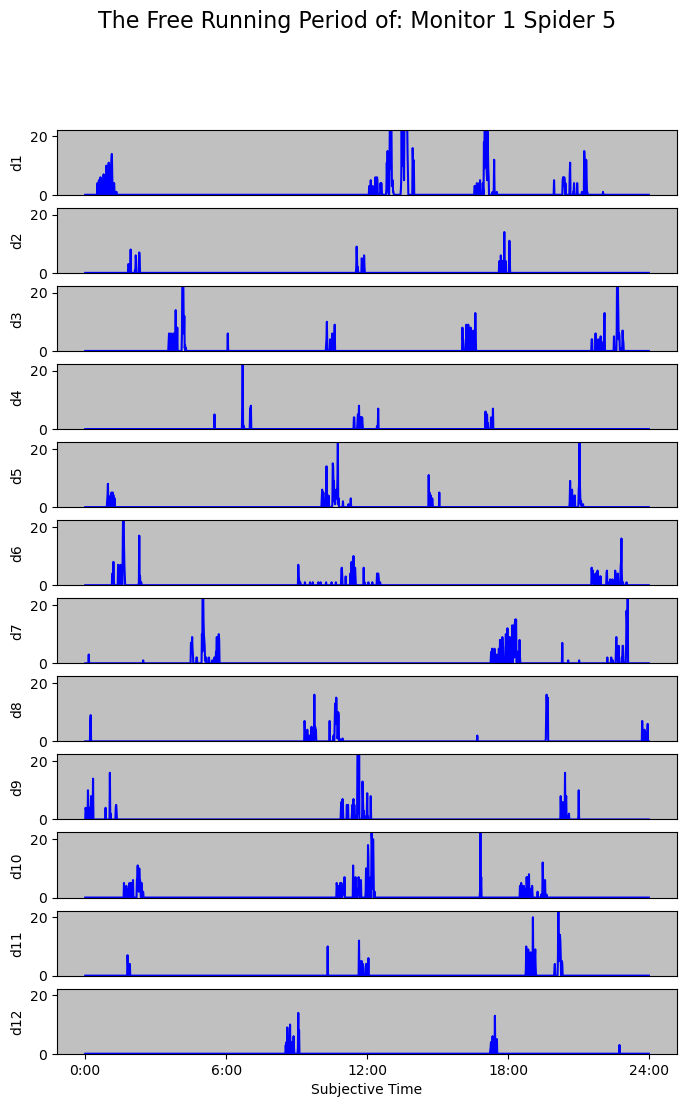

Next spider
Monitor 1 Spider 6


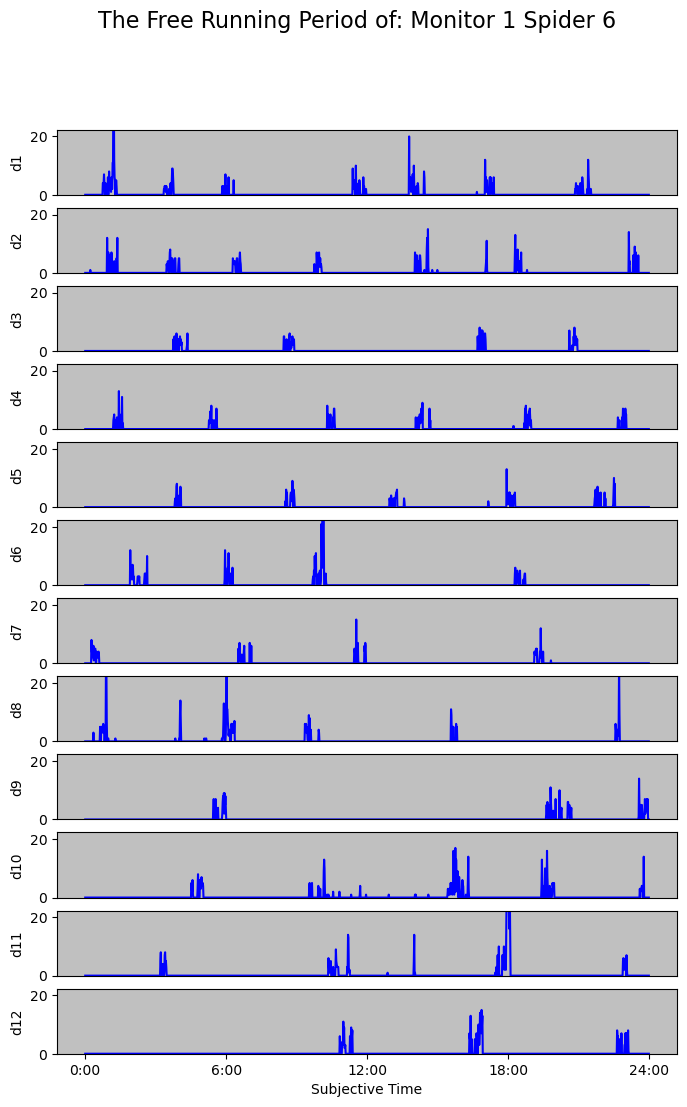

Next spider
Monitor 1 Spider 7


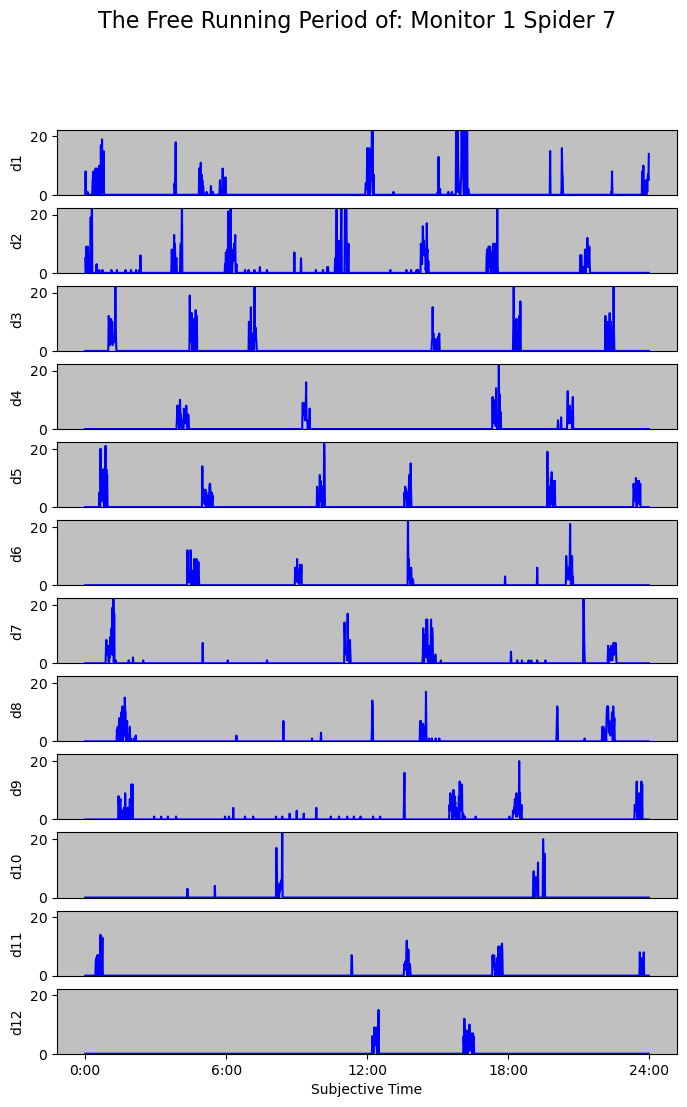

Next spider
Monitor 1 Spider 8


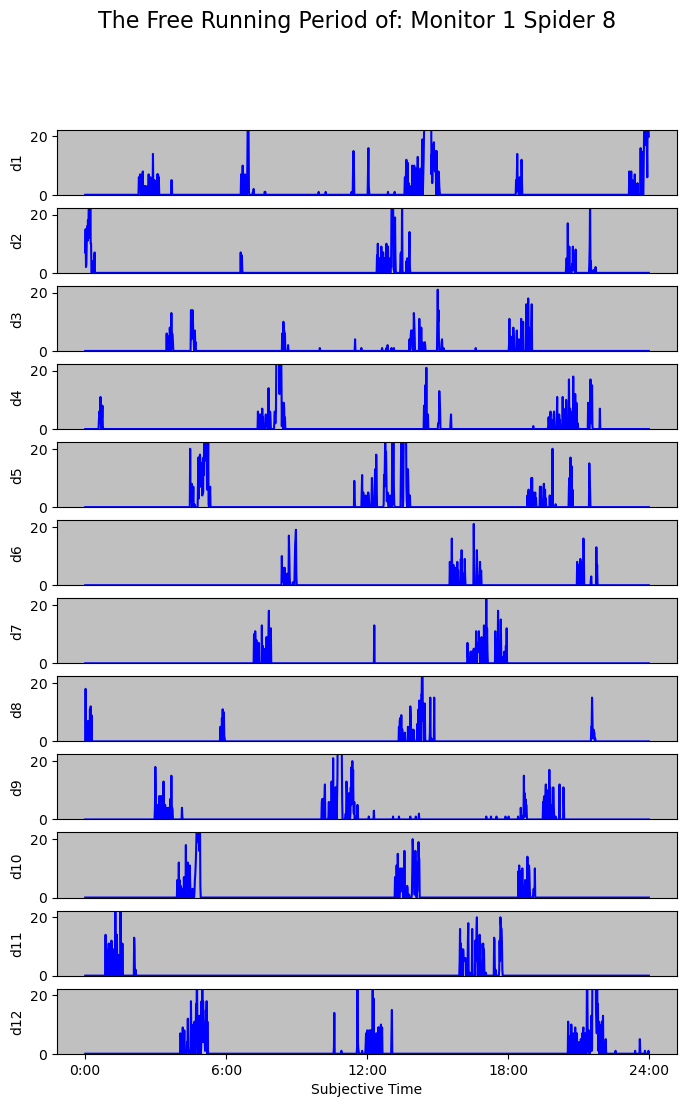

Next spider
Monitor 1 Spider 10


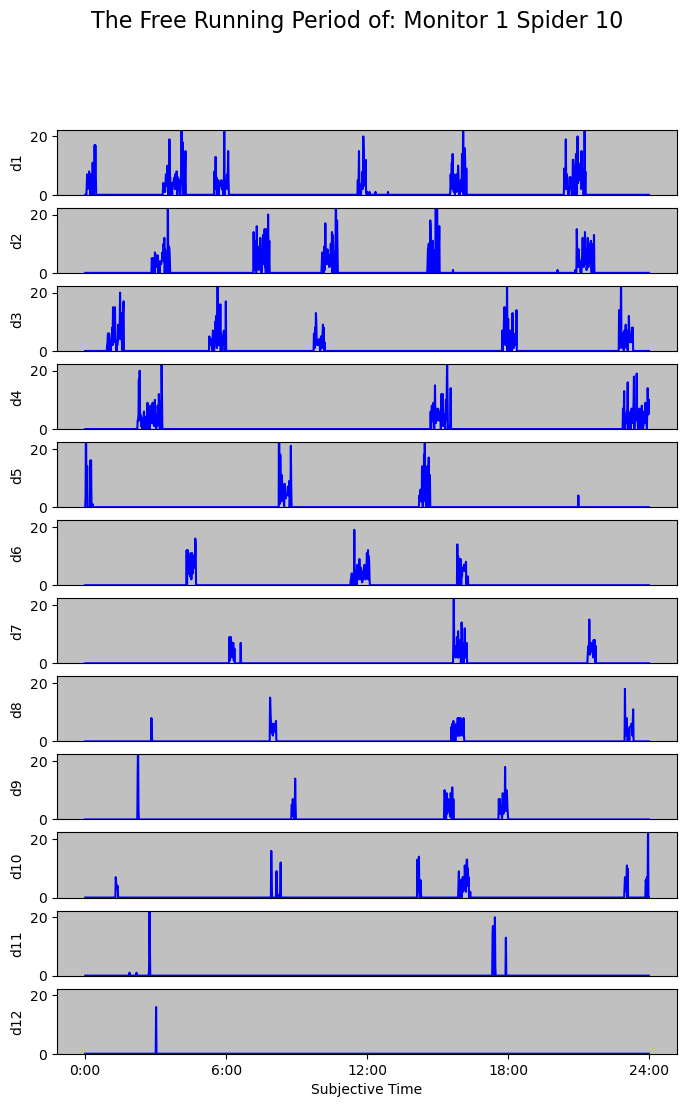

Next spider


In [32]:
spider_raster(df)

In [33]:
df_out=LS_Period_Amplitude_FalseAlarm_Pgram("Latrodectus mactans  Monitor 1 Updated_DD")
display(df_out)


column=df.columns[1:]
display(column)
per=pd.DataFrame(data=df_out['Period'],index=column)

['Monitor 1 Spider 1', 'Monitor 1 Spider 3', 'Monitor 1 Spider 4', 'Monitor 1 Spider 5', 'Monitor 1 Spider 6', 'Monitor 1 Spider 7', 'Monitor 1 Spider 8', 'Monitor 1 Spider 10']
8


/var/folders/wg/ym0rkfln7plgftl6_m51m7sc0000gn/T/ipykernel_35583/1485457656.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(df_add, ignore_index = True)     # add a row to the output datafram
/var/folders/wg/ym0rkfln7plgftl6_m51m7sc0000gn/T/ipykernel_35583/1485457656.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(df_add, ignore_index = True)     # add a row to the output datafram
/var/folders/wg/ym0rkfln7plgftl6_m51m7sc0000gn/T/ipykernel_35583/1485457656.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(df_add, ignore_index = True)     # add a row to the output datafram
/var/folders/wg/ym0rkfln7plgftl6_m51m7sc0000gn/T/ipyker

Spider     Period   Amplitude        p value
0   Monitor 1 Spider 1  21.779822    4.275112   1.000000e+00
1   Monitor 1 Spider 3  29.597167  607.606168  1.436579e-258
2   Monitor 1 Spider 4  14.507905  442.419479  6.731369e-187
3   Monitor 1 Spider 5  18.615482  138.361142   4.232057e-55
4   Monitor 1 Spider 6  21.411244   81.050564   2.512411e-30
5   Monitor 1 Spider 7  17.358748   70.775362   6.809529e-26
6   Monitor 1 Spider 8  30.281847  404.819383  1.375091e-170
7  Monitor 1 Spider 10  32.762244   80.889604   2.948242e-30

Index(['Monitor 1 Spider 1', 'Monitor 1 Spider 3', 'Monitor 1 Spider 4',
       'Monitor 1 Spider 5', 'Monitor 1 Spider 6', 'Monitor 1 Spider 7',
       'Monitor 1 Spider 8', 'Monitor 1 Spider 10'],
      dtype='object')

In [34]:
spider_raster_per(df, per)

Monitor 1 Spider 1


ValueError: cannot convert float NaN to integer